In [500]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer



In [501]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)

x_train_imputed['GAS_COAL_INTERACTION'] = x_train_imputed['DE_GAS'] * x_train_imputed['DE_COAL']
x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_test_imputed['GAS_COAL_INTERACTION'] = x_test_imputed['DE_GAS'] * x_test_imputed['DE_COAL']
x_test_imputed['DE_NET_EXPORT_cumsum'] = x_test_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()

scaler = StandardScaler()
x_train_scaled= scaler.fit_transform(x_train_imputed)
x_train_imputed = pd.DataFrame(x_train_scaled, columns=x_train_imputed.columns)




In [502]:
x_train_imputed.drop('ID', axis = 1, inplace = True)
y_train.drop('ID', axis = 1, inplace = True)


In [503]:
#Run baseline model
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)


mse_valid = cross_val_score(xgb_reg, x_train_imputed, y_train, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, x_train_imputed, y_train, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE : {-np.mean(mae_scores)}')




Average MSE : 1.456164219253718
Average MAE : 0.7373637598864017


In [504]:
xgb_reg.fit(x_train_imputed, y_train)
booster = xgb_reg.get_booster()
importance_dict = booster.get_fscore()
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame with sorted feature importances
feature_importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])
print("Feature Importances (Sorted):")
feature_importance_df

Feature Importances (Sorted):


,Feature,Importance
0,DE_NET_EXPORT_cumsum,731.0
1,DAY_ID,487.0
2,COUNTRY_DE,315.0
3,DE_CONSUMPTION,199.0
4,DE_NET_EXPORT,130.0
5,FR_CONSUMPTION,109.0
6,DE_FR_EXCHANGE,103.0
7,DE_RAIN,93.0
8,DE_GAS,89.0
9,DE_HYDRO,88.0


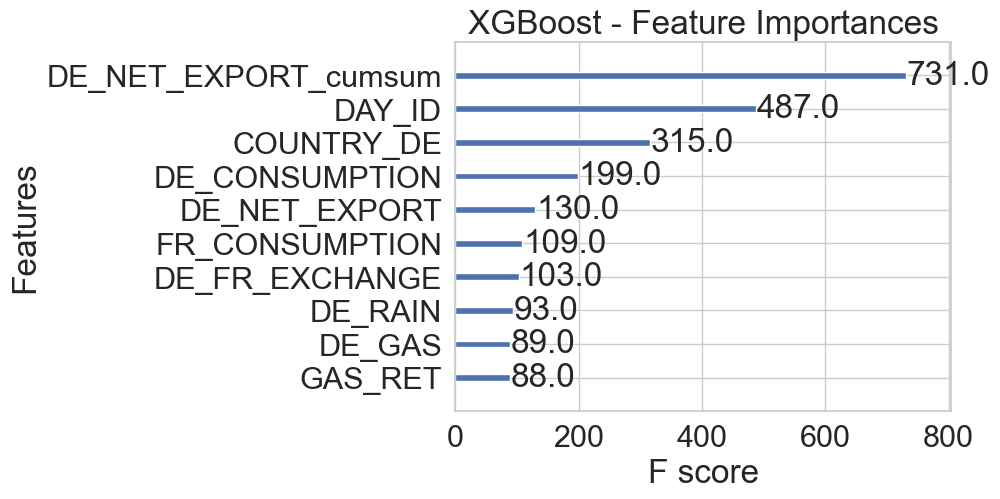

In [505]:
plot_importance(xgb_reg, max_num_features=10)  
plt.title('XGBoost - Feature Importances')
plt.show()

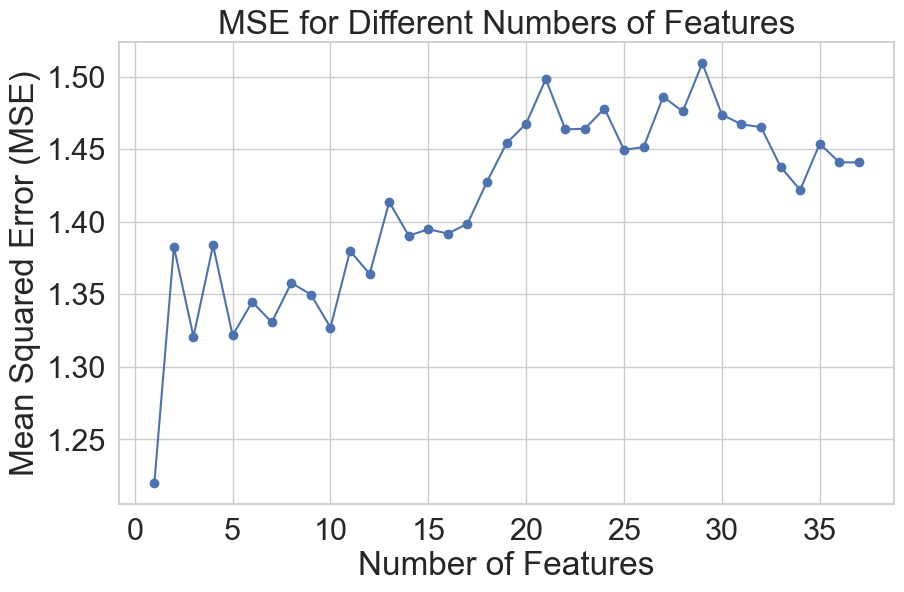

In [506]:
mse_scores_per_k = []

for k in range(1, len(x_train_imputed.columns) + 1):
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    xgb_reg_selected = XGBRegressor(objective='reg:squarederror', random_state=42)

    mse_scores = cross_val_score(xgb_reg_selected, x_train_imputed[selected_features], y_train, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(x_train_imputed.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('MSE for Different Numbers of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

    

In [509]:
#randomized grid search
param_grid = {
    'learning_rate': [0.001, 0.01, 0,1],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 2, 3],
    'min_child_weight': [1, 2, 3, 4]
}


random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_grid,
    n_iter=80,  
    scoring='neg_mean_squared_error', 
    cv=5,  
    random_state=42,
    n_jobs=-1  
)

random_search.fit(x_train_imputed, y_train)

print("Best Parameters:", random_search.best_params_)

# Get the best model
best_xgb_model = random_search.best_estimator_

mean_cv_score = random_search.best_score_
print(f'Mean Cross-Validated Score: {-mean_cv_score}')



Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.001, 'gamma': 0, 'colsample_bytree': 0.8}
Mean Cross-Validated Score: -1.056058380603847


In [508]:
xgb_reg = XGBRegressor(objective='reg:squarederror', subsample= 0.8, n_estimators= 400, min_child_weight= 1, max_depth= 6, learning_rate= 0.001, gamma= 0, colsample_bytree= 0.8, random_state=42)


mse_valid = cross_val_score(xgb_reg, x_train_imputed, y_train, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, x_train_imputed, y_train, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE : {-np.mean(mae_scores)}')

Average MSE : 1.056058380603847
Average MAE : 0.5614422281211244


In [ ]:
selected_features = [feature[0] for feature in sorted_importances[:k]]
xgb_reg_selected = XGBRegressor(objective='reg:squarederror', random_state=42)

    mse_scores = cross_val_score(xgb_reg_selected, X_train[selected_features], y_train, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

In [ ]:
#plot

In [ ]:
#grid search

In [369]:
from scipy.stats import spearmanr

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, subsample= 0.8, n_estimators= 100, min_child_weight= 3, max_depth= 7, learning_rate= 0.1, gamma= 3, colsample_bytree= 1.0)

xgb_reg.fit(X_train, y_train)

y_pred_valid = xgb_reg.predict(X_valid)

# Calculate Mean Squared Error (MSE) on the validation set
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print(f'Mean Squared Error (MSE) on Validation Set: {mse_valid}')

mape = np.mean(np.abs((y_valid.values - y_pred_valid) / y_valid.values)) * 100
print(f'MAPE on Validation Set: {mape}')

spearman_corr, _ = spearmanr(y_valid, y_pred_valid)
print(f'Spearman Correlation on Validation Set: {spearman_corr}')

#Best scores
#Mean Squared Error (MSE) on Validation Set: 7.784999248354407
#MAPE on Validation Set: 2.8618653631144144
#R-squared (R2) on Validation Set: 0.46214444261207904

Mean Squared Error (MSE) on Validation Set: 1.2191582527789
MAE on Validation Set: 0.6010474057931933
Spearman Correlation on Validation Set: 0.2720755987519921


In [289]:

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 2, 3],
    'min_child_weight': [1, 2, 3, 4]
}

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_grid,
    n_iter=80,  
    scoring='neg_mean_absolute_error', 
    cv=5,  
    random_state=42,
    n_jobs=-1  
)

# Perform the random search
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = best_xgb_model.predict(X_valid)

# Calculate Mean Squared Error (MSE) on the validation set
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print(f'Mean Squared Error (MSE) on Validation Set: {mse_valid}')

mape = mean_absolute_error(y_valid, y_pred_valid)*100

r2_valid = r2_score(y_valid, y_pred_valid)
print(f'R-squared (R2) on Validation Set: {r2_valid}')


Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 3, 'colsample_bytree': 1.0}
Mean Squared Error (MSE) on Validation Set: 7.51736519861917
R-squared (R2) on Validation Set: 0.49363027807002585


In [127]:
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,split2_test_score,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,1.0,100,3,5,0.1,1,1.0,-10.827410,-10.979065,-10.753194,-10.885711,1
1,0.8,100,3,7,0.1,3,1.0,-9.983666,-10.652715,-10.418576,-11.056241,2
2,1.0,500,2,4,0.1,2,1.0,-10.567186,-10.733000,-11.745149,-11.313779,3
3,1.0,100,1,9,0.1,3,1.0,-11.974902,-11.598879,-10.766708,-11.376335,4
4,0.8,500,4,5,0.1,3,1.0,-10.129935,-11.692681,-11.746287,-11.408944,5
5,0.8,200,1,6,0.1,0,1.0,-10.669003,-12.034504,-11.290859,-11.452134,6
6,1.0,400,1,6,0.2,1,1.0,-28.335530,-21.990288,-22.586179,-24.373064,7
7,0.9,300,1,4,0.2,2,1.0,-29.303764,-22.245725,-30.667149,-28.030275,8
8,1.0,500,4,8,0.3,0,1.0,-38.907278,-35.250090,-32.945325,-39.231638,9
9,1.0,300,2,7,0.3,3,1.0,-33.041754,-33.563134,-39.968285,-40.249595,10


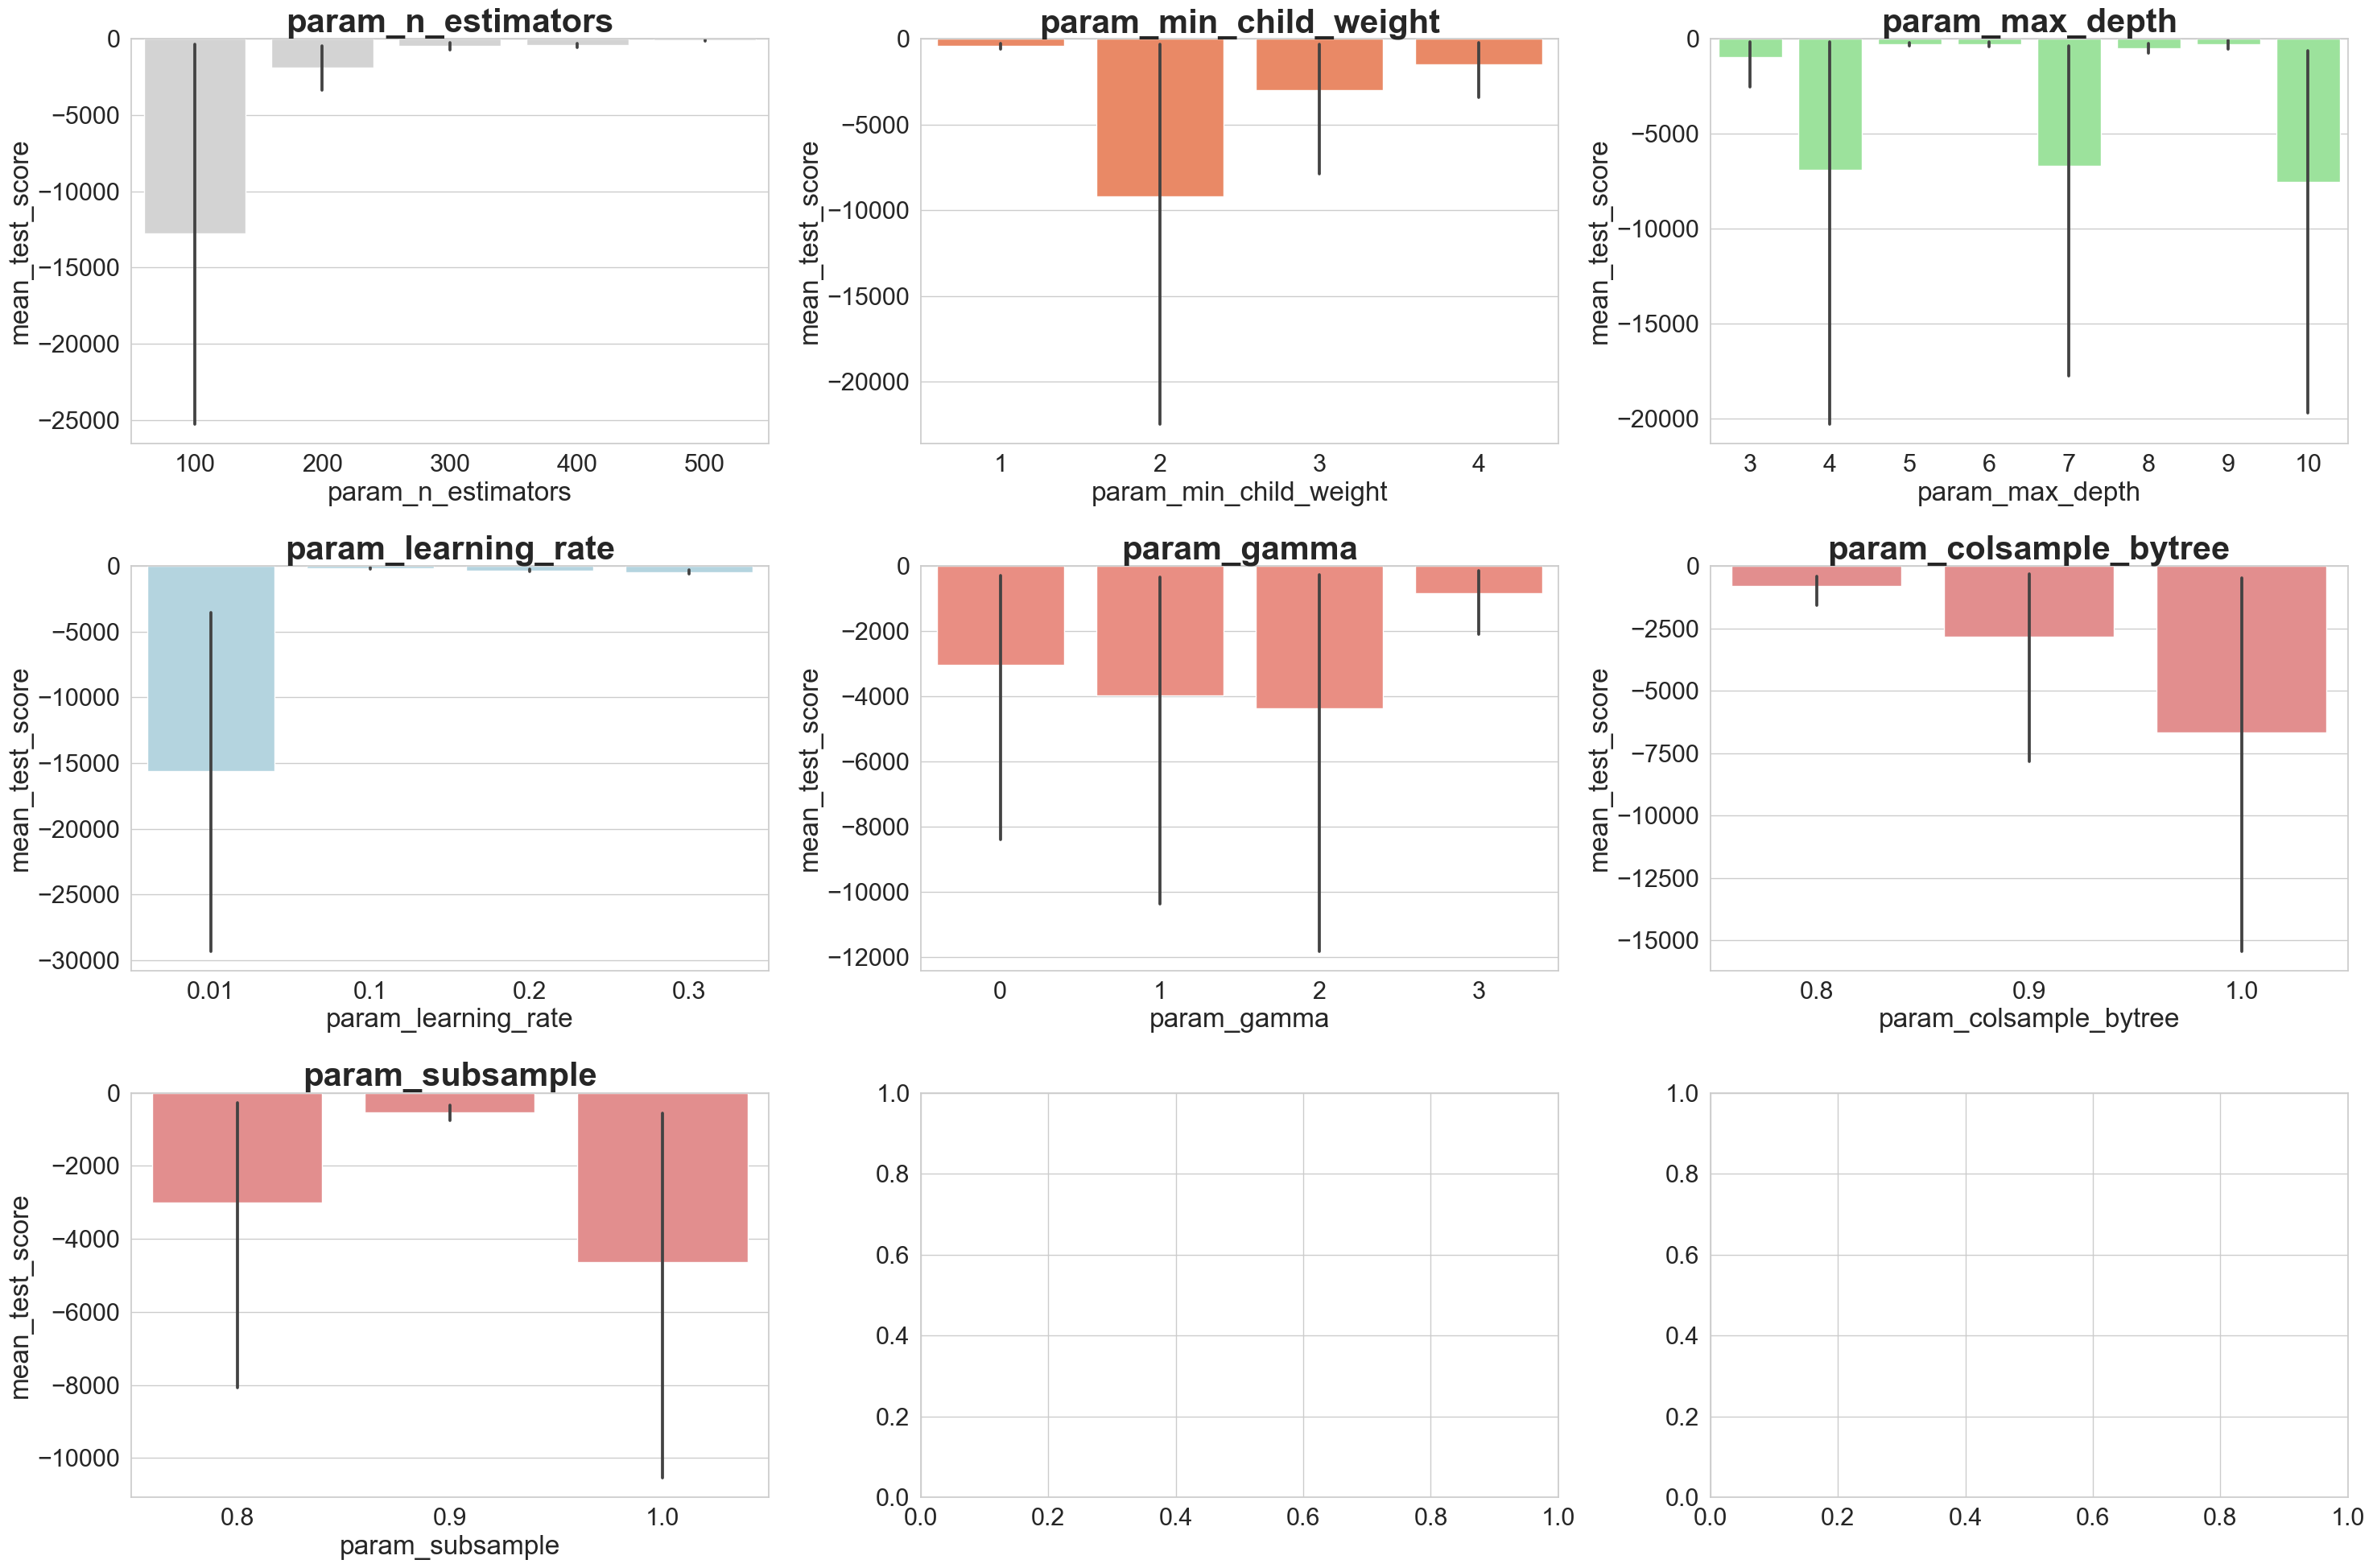

In [131]:

sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig, axs = plt.subplots(ncols=3, nrows=3)
fig.set_size_inches(30, 20)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0, 0], color='lightgrey')
axs[0, 0].set_title(label='param_n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_child_weight', y='mean_test_score', data=rs_df, ax=axs[0, 1], color='coral')
axs[0, 1].set_title(label='param_min_child_weight', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[0, 2], color='lightgreen')
axs[0, 2].set_title(label='param_max_depth', size=30, weight='bold')

sns.barplot(x='param_learning_rate', y='mean_test_score', data=rs_df, ax=axs[1, 0], color='lightblue')
axs[1, 0].set_title(label='param_learning_rate', size=30, weight='bold')

sns.barplot(x='param_gamma', y='mean_test_score', data=rs_df, ax=axs[1, 1], color='salmon')
axs[1, 1].set_title(label='param_gamma', size=30, weight='bold')

sns.barplot(x='param_colsample_bytree', y='mean_test_score', data=rs_df, ax=axs[1, 2], color='lightcoral')
axs[1, 2].set_title(label='param_colsample_bytree', size=30, weight='bold')

sns.barplot(x='param_subsample', y='mean_test_score', data=rs_df, ax=axs[2, 0], color='lightcoral')
axs[2, 0].set_title(label='param_subsample', size=30, weight='bold')


plt.tight_layout()
plt.show()


In [143]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.05],
    'n_estimators': [300, 400, 500],
    'max_depth': [5, 6, 8, 9],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [3, 0.5, 4],
}

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_grid,
    n_iter=80,  
    scoring='neg_mean_absolute_error', 
    cv=5,  
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_xgb_model = random_search.best_estimator_

y_pred_valid = best_xgb_model.predict(X_valid)

mse_valid = mean_squared_error(y_valid, y_pred_valid)
print(f'Mean Squared Error (MSE) on Validation Set: {mse_valid}')

r2_valid = r2_score(y_valid, y_pred_valid)
print(f'R-squared (R2) on Validation Set: {r2_valid}')


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}
Mean Squared Error (MSE) on Validation Set: 282.7214691193444
R-squared (R2) on Validation Set: 0.42655271267885925


In [ ]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())